# Simple Inference

In [55]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats

In [56]:
sns.set(color_codes=True)

## Estimating the Width of a Room

_Shortly after metric units of length were officially introduced in Australia in the 1970s, each of a group of 44 students was asked to guess, to the nearest meter, the width of the lecture hall in which they were sitting. Another group of 69 students in the same room was asked to guess the width in feet, ot the nearest foot. The main question is whether estimation in feet and in meters gives different results._

In [57]:
roomwidth = pd.read_csv('roomwidth.csv')
del roomwidth['Unnamed: 0']
roomwidth.head()

,unit,width
0,metres,8
1,metres,9
2,metres,10
3,metres,10
4,metres,10


In [58]:
def convert(row):
    if row['unit'] == 'metres':
        row['width'] *= 3.28
    return row

roomwidth = roomwidth.apply(convert, axis=1)
roomwidth.head()

,unit,width
0,metres,26.24
1,metres,29.52
2,metres,32.80
3,metres,32.80
4,metres,32.80


In [59]:
roomwidth[roomwidth['unit'] == 'metres'].describe()

,width
count,44.000000
mean,52.554545
std,23.434443
min,26.240000
25%,36.080000
50%,49.200000
75%,55.760000
max,131.200000


In [60]:
roomwidth[roomwidth['unit'] == 'feet'].describe()

,width
count,69.000000
mean,43.695652
std,12.497417
min,24.000000
25%,36.000000
50%,42.000000
75%,48.000000
max,94.000000


In [61]:
print(
    round(roomwidth[roomwidth['unit'] == 'feet']['width'].std(), 1), 
    round(roomwidth[roomwidth['unit'] == 'metres']['width'].std(), 1),
)

12.5 23.4


/Users/j.seporaitis/.virtualenvs/hsaur/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


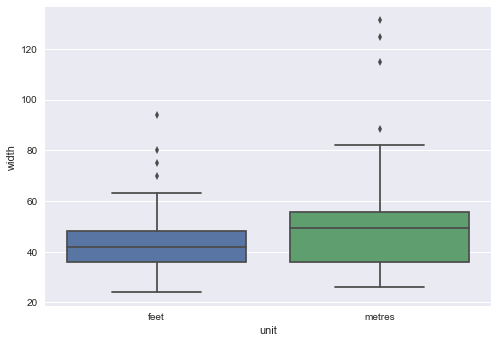

In [62]:
sns.boxplot(x="unit", y="width", data=roomwidth, order=['feet', 'metres'])

_The boxplots indicate that both sets of estimates contain a number of outliers and also that the estimates made in meters are skewed and more variable than those made in feet, a point underlined by the numerical summary statistics above. Both normal probability plots depart from linearity, suggesting that the distributions of both sets of estimates are not normal. The presence of outliers, the apparently different variances and the evidence of non-normality all suggest caution in applying the t-test, but for the moment we shall apply the usual version of the test._

In [63]:
roomfeet = roomwidth[roomwidth['unit'] == 'feet']
roommetres = roomwidth[roomwidth['unit'] == 'metres']

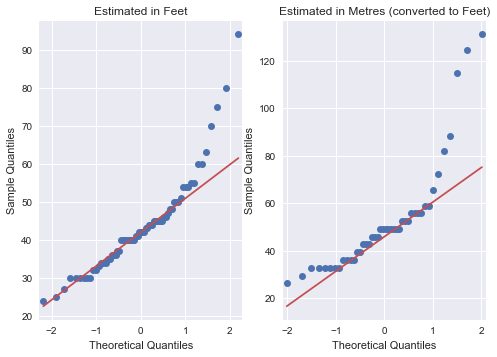

In [64]:
fig, ax = plt.subplots(ncols=2)
sm.qqplot(roomfeet['width'], ax=ax[0], line='q')
ax[0].set_title("Estimated in Feet")
sm.qqplot(roommetres['width'], ax=ax[1], line='q')
ax[1].set_title("Estimated in Metres (converted to Feet)")
plt.show()

In [74]:
tvalue, pvalue = stats.ttest_ind(
    a=roomfeet['width'],
    b=roommetres['width'],
)
print("Student t-test")
print("t-value", tvalue, "p-value", pvalue, "df", (len(roomfeet['width']) + len(roommetres['width']) - 2))

print("mean in group feet", roomfeet['width'].mean())
print("mean in group metres", roommetres['width'].mean())

cm = sms.CompareMeans.from_data(roomfeet['width'], roommetres['width'])
cil, cir = cm.tconfint_diff(usevar='pooled')
print("confidence interval", cil, cir)

Student t-test
t-value -2.6146714459044005 p-value 0.010171723177660002 df 111
mean in group feet 43.69565217391305
mean in group metres 52.55454545454545
confidence interval -15.572734308913141 -2.145052252351661


In [77]:
tvalue, pvalue = stats.ttest_ind(
    a=roomwidth[roomwidth['unit'] == 'feet']['width'],
    b=roomwidth[roomwidth['unit'] == 'metres']['width'],
    equal_var=False,
)
print("Welch t-test")
print("t-value", tvalue, "p-value", pvalue)

print("mean in group feet", roomfeet['width'].mean())
print("mean in group metres", roommetres['width'].mean())

cm = sms.CompareMeans.from_data(roomfeet['width'], roommetres['width'])
cil, cir = cm.tconfint_diff(usevar='unequal')
print("confidence interval", cil, cir)

Welch t-test
t-value -2.307068877727352 p-value 0.024591776613301364
mean in group feet 43.69565217391305
mean in group metres 52.55454545454545
confidence interval -16.543076596191433 -1.174709965073382


_But this form of t-test assumes both normality and equality of population variances, both of which are suspect for these data. Departure from the equality of variance assumption can be accommodated by the modified t-test described above and this can be applied by choosing_ `equal_var=False`. _The result above indicates that there is strong evidence for a difference in the means of the two types of estimates._

_But there remains the problem of the outliers and the possible non-normality; consequently we shall apply the Wilcoxon Mann-Whitney test which, since it is based on the ranks of the observations, is unlikely to be affected by the outliers, and which does not assume that the data have a normal distribution._

In [124]:
U, pvalue = stats.mannwhitneyu(roomfeet['width'], roommetres['width'])
print("U", U, "p-value", pvalue)

U 1145.0 p-value 0.01407739440756384


_A two-sided p-value_ `0.014 * 2 = 0.028` _confirms the difference in location of the two types of estimates of room width. Note that, due to ranking the observations, the confidence interval for the median difference reported here is much smaller than the confidence interval for the differenece in means in both t-tests._

In [139]:
# Based on R algorithm: https://github.com/wch/r-source/blob/trunk/src/library/stats/R/wilcox.test.R#L143
alpha = 1 - 0.95
mu = roomwidth['width'].mean()
x = roomwidth['width'] + mu
mumin, mumax = x.min(), x.max()

# TODO: ...